In [1]:
import torch,sys,os
from torch import nn
from tqdm import tqdm
import random
import numpy as np
from argparse import ArgumentParser
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
if "__file__" in globals():
    main_folder_path = os.path.abspath(os.path.join(os.path.dirname(__file__), ".."))
else:
    main_folder_path = os.path.abspath(os.path.join(os.getcwd(), ".."))
sys.path.append(main_folder_path)


In [2]:
from baseclasses.baseclass import BaseTrainer
from architectures.mlpRegressor import MLP_Regressor
from dataloaders.dataloaders import WineQualityLoader
from trainers.trainer_mlpRegressor import MLPRegressorTrainer
from algorithms.feature_CP import ConformalPredictionMethods 

In [3]:
parser = ArgumentParser()
parser.add_argument('--device', type=str, default='cuda:0', help='device to run the model on')
args, unknown = parser.parse_known_args()
print(f"using device:{args.device}")

using device:cuda:0


In [4]:
dataloader_instance = WineQualityLoader(args)
dataloader_instance.load_full_data()
dataloader_instance.load_split_data(0.5)
X_train,y_train,x_test,y_test = dataloader_instance.get_data()
X_calib,y_calib = dataloader_instance.get_calibration_set()

Loaded full wine quality dataset with shape: torch.Size([6497, 11]),torch.Size([6497, 1])
Loaded split wine quality dataset with train shape: torch.Size([3248, 11]) 
 test sizetorch.Size([1624, 11]),calibration size torch.Size([1624, 11]) 


In [5]:
trainer_instance = MLPRegressorTrainer(args)
trainer_instance.train_setup(train_data=torch.cat((X_train,y_train),dim=1), valid_data=None)
trainer_instance.train()

setup a MLP regression network structure with [11, 64, 64, 32], dropout prob: 0.2


MLP Regression Model Training:   0%|          | 3/1000 [00:00<01:32, 10.76it/s]

[1] current epoch total loss: 893.0481109619141


MLP Regression Model Training:   5%|▌         | 53/1000 [00:03<00:51, 18.33it/s]

[51] current epoch total loss: 28.51795470714569


MLP Regression Model Training:  10%|█         | 103/1000 [00:06<00:49, 18.30it/s]

[101] current epoch total loss: 23.504009544849396


MLP Regression Model Training:  15%|█▌        | 153/1000 [00:08<00:51, 16.61it/s]

[151] current epoch total loss: 22.545521676540375


MLP Regression Model Training:  20%|██        | 203/1000 [00:11<00:46, 17.01it/s]

[201] current epoch total loss: 19.721232891082764


MLP Regression Model Training:  25%|██▌       | 253/1000 [00:15<00:43, 17.14it/s]

[251] current epoch total loss: 19.075471699237823


MLP Regression Model Training:  30%|███       | 303/1000 [00:18<00:41, 16.77it/s]

[301] current epoch total loss: 17.032732367515564


MLP Regression Model Training:  35%|███▌      | 353/1000 [00:21<00:37, 17.27it/s]

[351] current epoch total loss: 16.316152691841125


MLP Regression Model Training:  40%|████      | 403/1000 [00:24<00:32, 18.51it/s]

[401] current epoch total loss: 14.548707276582718


MLP Regression Model Training:  45%|████▌     | 453/1000 [00:26<00:29, 18.58it/s]

[451] current epoch total loss: 13.977482318878174


MLP Regression Model Training:  50%|█████     | 503/1000 [00:29<00:30, 16.15it/s]

[501] current epoch total loss: 13.441630363464355


MLP Regression Model Training:  55%|█████▌    | 553/1000 [00:32<00:26, 16.80it/s]

[551] current epoch total loss: 13.023340821266174


MLP Regression Model Training:  60%|██████    | 603/1000 [00:36<00:24, 16.51it/s]

[601] current epoch total loss: 12.15843179821968


MLP Regression Model Training:  65%|██████▌   | 653/1000 [00:39<00:20, 17.15it/s]

[651] current epoch total loss: 11.663990050554276


MLP Regression Model Training:  70%|███████   | 703/1000 [00:42<00:19, 15.17it/s]

[701] current epoch total loss: 11.641926497220993


MLP Regression Model Training:  75%|███████▌  | 753/1000 [00:45<00:14, 16.58it/s]

[751] current epoch total loss: 11.04228487610817


MLP Regression Model Training:  80%|████████  | 803/1000 [00:48<00:11, 17.51it/s]

[801] current epoch total loss: 10.832828044891357


MLP Regression Model Training:  85%|████████▌ | 853/1000 [00:51<00:08, 18.08it/s]

[851] current epoch total loss: 10.633264660835266


MLP Regression Model Training:  90%|█████████ | 903/1000 [00:54<00:05, 17.94it/s]

[901] current epoch total loss: 10.696635663509369


MLP Regression Model Training:  95%|█████████▌| 953/1000 [00:57<00:02, 17.76it/s]

[951] current epoch total loss: 10.235099613666534


MLP Regression Model Training: 100%|██████████| 1000/1000 [00:59<00:00, 16.75it/s]


In [6]:
trainer_instance.calibration_setup(calib_data=torch.cat((X_calib,y_calib),dim=1))

Setup calibration set, data shape: torch.Size([1624, 12])


In [19]:
trainer_instance.model.eval()
u_feat = trainer_instance.model.feature_func_forward(trainer_instance.calib_data[:,:-1])
y_pred = trainer_instance.model.predictor_head_forward(u_feat)
abs = torch.abs(y_pred.squeeze(-1) - trainer_instance.calib_data[:,-1])
grad_norm = torch.norm(torch.autograd.grad(y_pred[0],u_feat,allow_unused=True,retain_graph=True)[0][0],p=2)
scores = abs/grad_norm
cpmethods = ConformalPredictionMethods()
Q_corrected = cpmethods.weighted_quantile(scores,0.9,torch.ones_like(scores)) * grad_norm
bandwidth = 2 * Q_corrected
bandwidth


feature function output shape: torch.Size([1624, 32])


tensor(2.3048, device='cuda:0', grad_fn=<MulBackward0>)

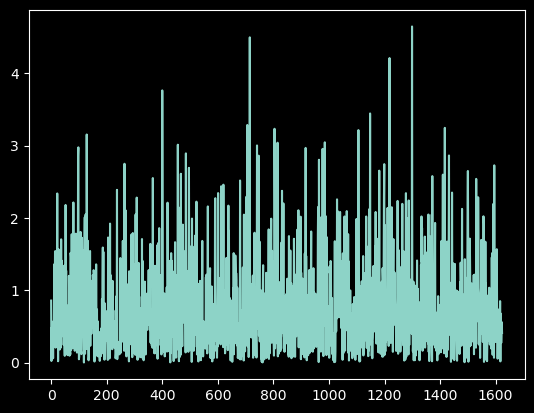

In [9]:
import matplotlib.pyplot as plt
plt.plot(scores.cpu().detach().numpy())
plt.show()